<a href="https://colab.research.google.com/github/51rL1N5/Prova_Esig/blob/master/taxi_fare.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [287]:
import pandas as pd
import numpy as np
import seaborn as sbs
from haversine import haversine
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.gridspec import GridSpec

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.figure_factory as ff
import plotly.tools as tls
import plotly.graph_objs as go


import folium
import folium.plugins


from bokeh.models import BoxZoomTool
from bokeh.plotting import figure, output_notebook, show
import datashader as ds
from datashader.bokeh_ext import InteractiveImage
from functools import partial
from datashader.utils import export_image
from datashader.colors import colormap_select, Greys9, Hot, inferno,Set1
from datashader import transfer_functions as tf
output_notebook()


Loading BokehJS ...

In [0]:
# Como o banco de dados é muito grnade, irei analizar-lo por blocos
# Que são suficientemente grandes para podermos supor que representam bem uma aproximação
# da estatística global.

# Logo após processar todos eles, é necessário fazer uma média das análises (estacionaridade)


chunksize = 10 ** 6

chunk = pd.read_csv('train.csv', nrows=chunksize)

In [229]:
# Olhando a cara dos dados

chunk.head()

,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [0]:
# Primeiro, vamos limpar os dados 

"""
----- Limpeza de coordenadas -------------

Sei que a latitude é um número limitado entre -90 <= lat <= 90  
Bem como a longitude é limitada entre -180 <= long <= 180

Então, irei eliminar dados que apresentarem esses dados expúrios

"""

chunk = chunk[
               ( abs(chunk['pickup_latitude']) <= 90 ) & ( abs(chunk['pickup_longitude']) <= 180 ) & ( abs(chunk['dropoff_latitude']) <= 90 ) & ( abs(chunk['dropoff_longitude']) <= 180 )
             ]

"""
----- Limpeza de taxas -------------------

Não faz sentido que tenhamos preço pago negativo
Logo, eliminaremos os dados que possuam tal característica

"""

chunk = chunk[
               (chunk['fare_amount'] >= 0)
             ]

"""
----- Limpeza do número de passageiros ------

De acordo com https://www1.nyc.gov/nyc-resources/faq/484/how-many-passengers-are-allowed-in-a-taxi

No máximo 4 ou 5, acrescido de uma criança abaixo de 7 anos (que ficará no colo de um adulto) poderão ir no taxi

Logo, no máximo teremos 6 passageiros
"""

chunk = chunk[
               (chunk['passenger_count'] <=6)
             ]

"""
----- Remover, caso existam, dados nulos (faltantes) -------------
"""
chunk = chunk.drop(chunk[chunk.isnull().any(1)].index, axis=0)

In [231]:
# Agora, criaremos um indicador de distancia percorrida, bem como criarei mais colunas
# Com mais informação util, como Dia, Mês, Ano, hora, minuto, segundo


# Para calcularmos a distancia, se faz necessário usar a formula de haversine que pega dois pontos em uma esfera (latitude e longitude) e converte para distancia em metros

def haversine_1 (lat1, long1, lat2, long2):
  
  # Lambda é a longitude
  # Phi é a latitude
  R = 6371 # raio da terra em km

  phi_1 = np.radians(chunk[lat1])
  phi_2 = np.radians(chunk[lat2])

  delta_phi    = np.radians(chunk[lat2] - chunk[lat1])
  delta_lambda = np.radians(chunk[long2] - chunk[long1])

  #a = sin²((φB - φA)/2) + cos φA . cos φB . sin²((λB - λA)/2)
  a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi_1) * np.cos(phi_2) * np.sin(delta_lambda / 2.0) ** 2

  #c = 2 * atan2( √a, √(1−a) )
  c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))


  #d = R*c
  d = (R * c) # distancia em km

  chunk['distancia'] = d 
  return d
                                 

haversine_1('pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')

0          1.030764
1          8.450134
2          1.389525
3          2.799270
4          1.999157
5          3.787239
6          1.555807
7          4.155444
8          1.253232
9          2.849627
10         1.374577
11         0.000000
12         0.717767
13         2.019384
14         1.671445
15         0.000000
16         2.609774
17         1.511904
18         0.921952
19         0.399179
20         1.686861
21         2.292470
22         0.924296
23         1.403958
24         1.017773
25         2.531947
26         0.000000
27         0.328771
28         4.073463
29         0.808153
            ...    
999970     1.800660
999971    16.888650
999972     0.443274
999973     0.509990
999974     6.774274
999975     9.357706
999976     4.093045
999977     5.314221
999978     1.842736
999979     3.689741
999980     4.456025
999981     3.622864
999982     1.162477
999983     0.806466
999984     8.401025
999985     1.344648
999986     0.821492
999987     0.240398
999988     0.000000


In [0]:
# converter string para date_time, para obtermos os dados temporais

chunk['key']             = pd.to_datetime(chunk['key'])

chunk['pickup_datetime'] = pd.to_datetime(chunk['pickup_datetime'])

In [233]:
# Olhando a cara dos atributos dos dados após a conversão

chunk.dtypes

key                  datetime64[ns]
fare_amount                 float64
pickup_datetime      datetime64[ns]
pickup_longitude            float64
pickup_latitude             float64
dropoff_longitude           float64
dropoff_latitude            float64
passenger_count               int64
distancia                   float64
dtype: object

In [0]:
# Separando os dados temporais para podermos visualizar-los melhor

chunk['Ano'] = chunk['pickup_datetime'].dt.year
chunk['Mes'] = chunk['pickup_datetime'].dt.month
chunk['Dia'] = chunk['pickup_datetime'].dt.day
chunk['Dia da semana'] = chunk['pickup_datetime'].dt.dayofweek
chunk['Horario'] = chunk['pickup_datetime'].dt.hour

In [0]:
# Colocar variáveis de estado para
# se está de:
# noite
# madrugada

def noite(x):
  if ((x['Horario'] <=20) & (x['Horario'] >=17) ):
    return 1
  else:
    return 0

def madrugada(x):
  if ((x['Horario'] <= 5) | (x['Horario'] >=21) ):
    return 1
  else:
    return 0
  
chunk['Noite'] = chunk.apply(lambda x: noite(x), axis=1)
chunk['Madrugada'] = chunk.apply(lambda x: madrugada(x), axis=1)


# **Análise exploratória de dados**

---



**Como é cobrada a taxa de taxi em NYC:**

1 - A taxa inicial é de **$2.50**

2 - Mais  **50 cents ** a cada 1/5 de Milha (0,321869 km) acima de 12 mph (19,3121 km/h) ou a cada minuto em tráfico devagar

3 - **50 cents**  de taxa adicional para todas viagens que terminam em NYC, Nassau, Suffolk, Westchester, Rockland, Dutchess, Orange ou Putnam Counties

4 - ** 30 cents** de taxa de melhoramento

5 - ** 50 cents ** de taxa para tráfego entre **8pm** e **6am**

6 - ** $1.00 ** de taxa de hora do rush (**4pm ate 8pm**) em dias de semana, não se aplicando a feriados

7 -  Taxa de congestionamento de ** 2.50 ** (Taxi amarelo) , ** 2.75** (Taxi verde ou FHV) ou **75 cents** para corridas compartilhadas para todas as corridas que começam, terminam ou passam por Manhattan south of 96th street

8 - Pedágios e gorjetas são acrescidos caso necessário

**Hipóteses:**

1 - O Número de pessoas impacta no valor da taxa

2 - O horário o qual o taxi foi pego impacta no valor

3 - O dia da semana o qual o taxi foi pego impacta no valor

4 - Os meses impactam no valor da taxa?

5 - O local de origem do taxi tem relação com a taxa?

6 - A distância percorrida impacta no valor da taxa



#**Análise de correlação dos dados**

---



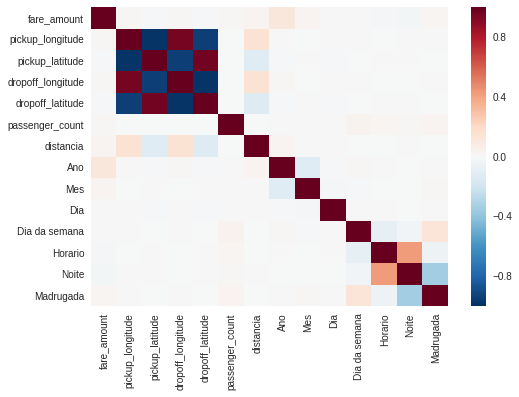

In [294]:
# Primeiro, vamos observar uma correlação dos dados para saber o que buscar de maneira mais eficiente

# corr = np.array(chunk[[
#                         'fare_amount','distancia',
#                         'Horario','Ano','Mes','Dia',
#                         'Dia da semana'
#                      ]].corr()
#                )

# tags = [
#           'fare_amount','distancia',
#           'Horario','Ano','Mes','Dia',
#           'Dia da semana'
#        ]

# corr  =  np.around(corr,7)

# fig = ff.create_annotated_heatmap(z = corr, x = tags, y = tags, showscale=True,
#                                   colorscale = "Portland",
#                                   colorbar   = dict(title = 'Coeficiente de correlação',
#                                                     titleside = 'right'
#                                                    )
#                                  )

# # Vamos plotar um mapa de calor 


# fig.layout.title = "Matriz de correlação"
# fig.layout.margin = dict(l=200, r = 200)

# py.iplot(fig)


corr = chunk.corr()

sbs.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values)

In [286]:
!pip install datashader

    100% |████████████████████████████████| 11.3MB 3.6MB/s 
    100% |████████████████████████████████| 1.4MB 18.5MB/s 
    100% |████████████████████████████████| 71kB 23.5MB/s 
    100% |████████████████████████████████| 81kB 25.0MB/s 
    100% |████████████████████████████████| 163kB 28.7MB/s 
  Stored in directory: /root/.cache/pip/wheels/8d/06/05/c1cba3d57bdcfd3960e3f60a9fdc97e4baef2ef09af0ad1ef8
  Stored in directory: /root/.cache/pip/wheels/26/1e/e8/4fa236ec931b1a0cdd61578e20d4934d7bf188858723b84698
Successfully built datashape locket
  Found existing installation: testpath 0.4.2
    Uninstalling testpath-0.4.2:
      Successfully uninstalled testpath-0.4.2


##**Hipótese 1**

---
O número de pessoas impacta no valor da taxa?


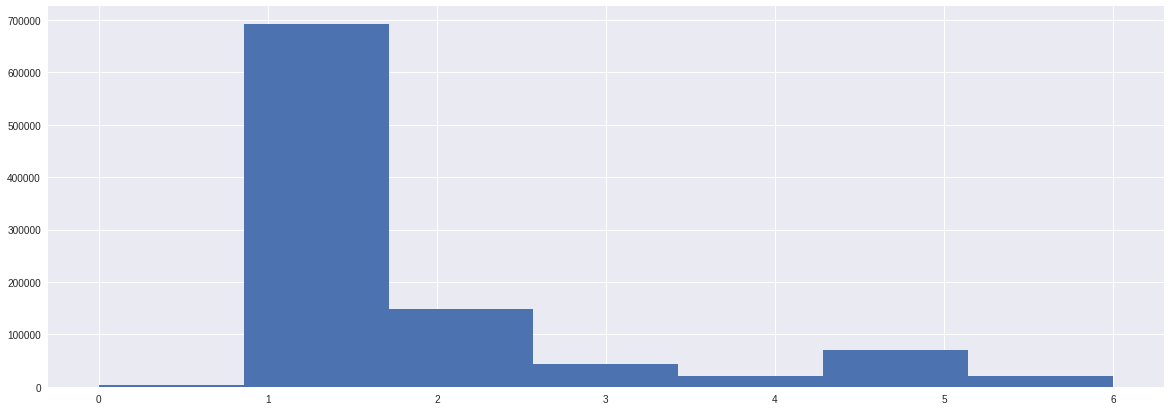

In [235]:
# Inicialmente, vamos ver a distribuição do número de pessoas

plt.figure(figsize=(20,7))

chunk['passenger_count'].hist(bins=7)

Text(0, 0.5, 'Taxa paga')

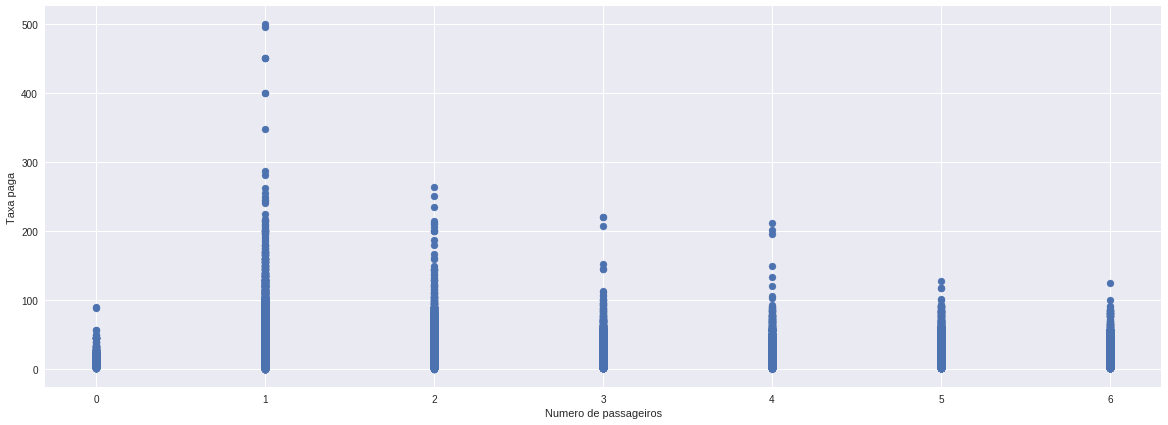

In [236]:
# Agora, é interessante ver como está a distribuição de número de passageiros x taxa paga

plt.figure(figsize=(20,7))

plt.scatter(x=chunk['passenger_count'], y=chunk['fare_amount'])
plt.xlabel('Numero de passageiros')
plt.ylabel('Taxa paga')

Dos dois gráficos, podemos inferir que a viagem de taxi para 1 passageiro é mais frequente. As taxas pagas mais altas também vem da viagem para 1 passageiro

#**Hipótese 2**

---

O horário impacta na taxa paga?

Text(0, 0.5, 'Frequencia')

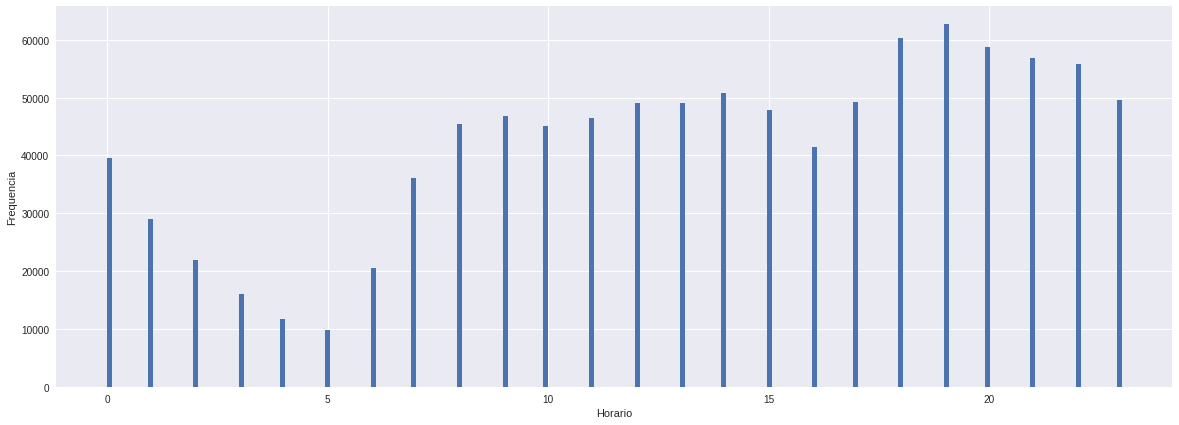

In [237]:
# Primeiro vamos estudar como está distribuida o horário os quais os taxis são pegos

plt.figure(figsize=(20,7))

chunk['Horario'].hist(bins=200)
plt.xlabel('Horario')
plt.ylabel('Frequencia')

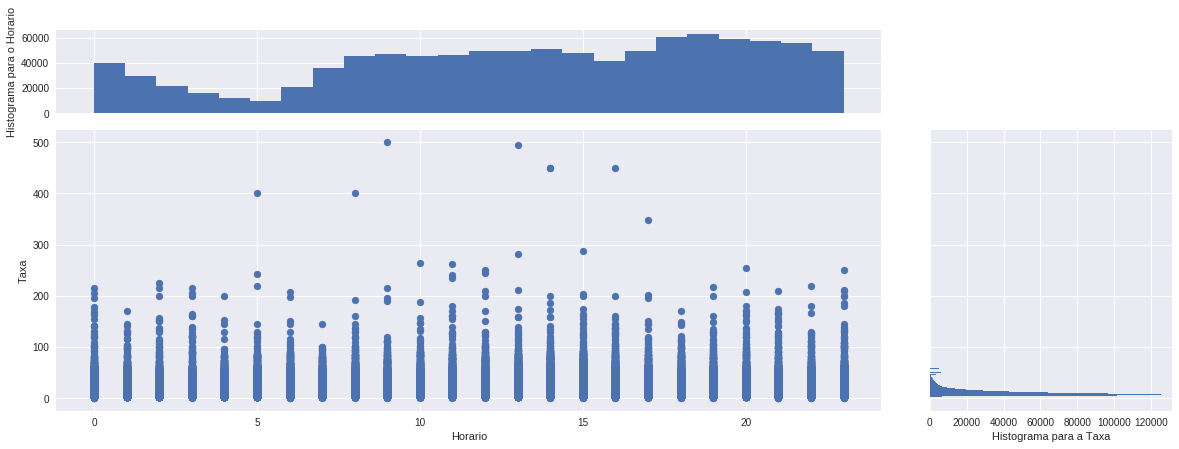

In [238]:


# plt.figure(figsize=(20,7))

# plt.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
# plt.xlabel('Horario')
# plt.ylabel('Taxa paga')


# Vamos ver como fica a distribuição do preço pago pelo horário


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['fare_amount'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()




(0, 20)

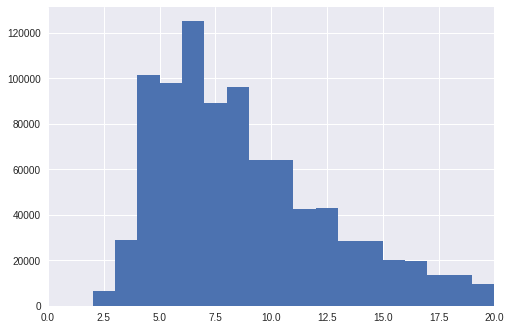

In [239]:
plt.hist(chunk['fare_amount'],bins=500)
plt.xlim((0,20))

In [240]:
chunk['fare_amount'].describe()

count    999911.000000
mean         11.348597
std           9.821236
min           0.000000
25%           6.000000
50%           8.500000
75%          12.500000
max         500.000000
Name: fare_amount, dtype: float64

Dos gráficos podemos inferir que ocorrem mais viagens entre as 18h e 21h, que é o horário em que geralmetne as pessoas voltam de seus trabalhos para casa. Todavia, o horário não parece impactar tanto no preço.

Também, vemos que a maioria das viagens custam, em média, 11.35 com um desvio padrão de 9.82


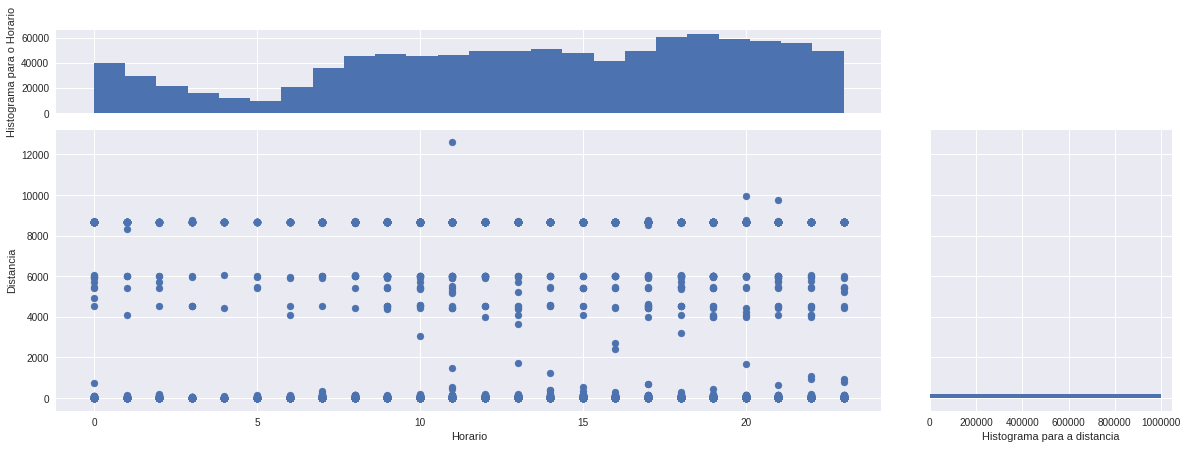

In [241]:
# Mas será que o horário impacta na distancia viajada?


fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])

ax_joint.scatter(x=chunk['Horario'], y=chunk['distancia'])
ax_marg_x.hist(chunk['Horario'], bins=24)
ax_marg_y.hist(chunk['distancia'],orientation="horizontal",bins=70)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Horario')
ax_joint.set_ylabel('Distancia')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a distancia')
ax_marg_x.set_ylabel('Histograma para o Horario')
plt.show()


Vemos que não, o horário não impacta na distância viajada.

#**Hipótese 3**


---
O dia da semana o qual o taxi foi pego impacta no valor?


Text(0, 0.5, 'Frequencia')

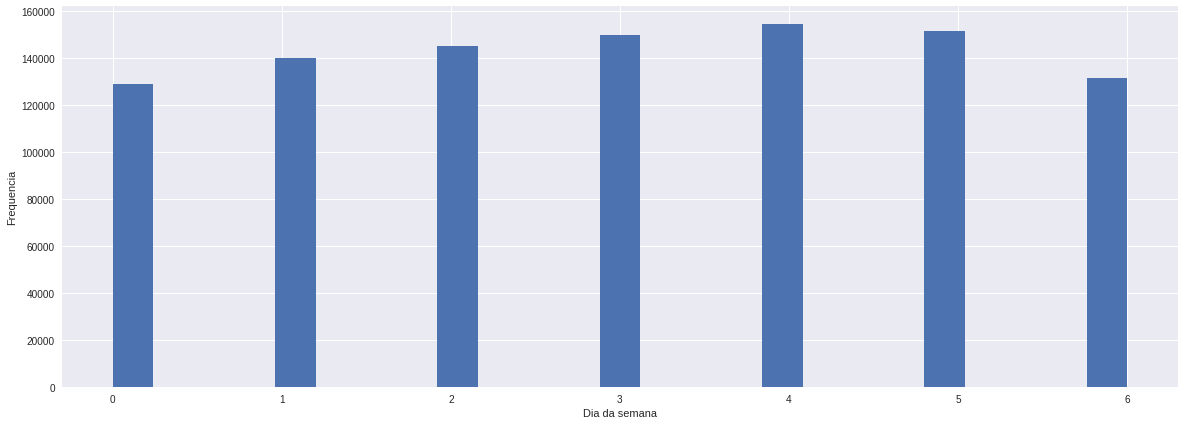

In [242]:
# Primeiro vamos estudar como está distribuida a demanda por taxis ao longo dos dias da semana

plt.figure(figsize=(20,7))

chunk['Dia da semana'].hist(bins=25)
plt.xlabel('Dia da semana')
plt.ylabel('Frequencia')

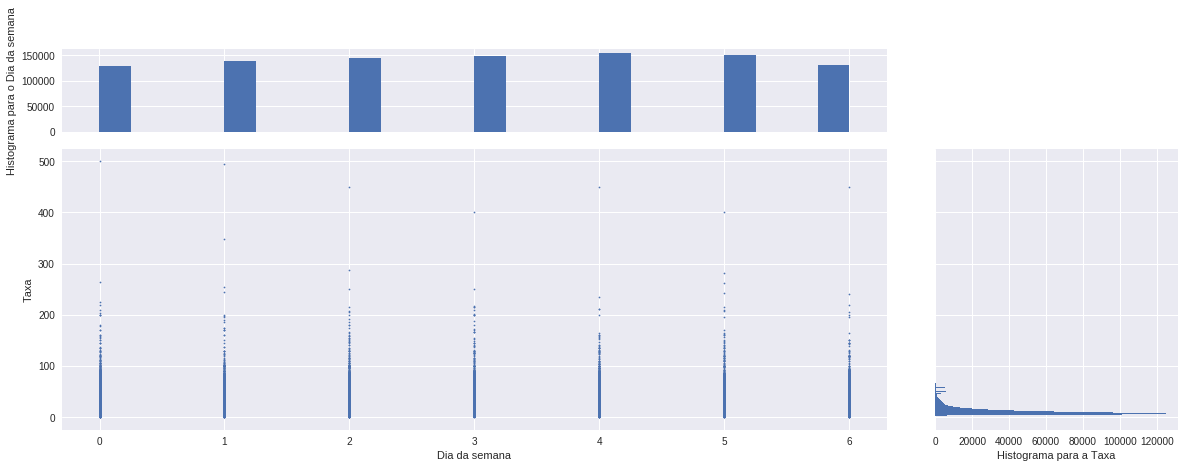

In [252]:
# Qual é a relação entre o dia da semana e ataxa paga?

fig = plt.figure(figsize=(20,7))

gs = GridSpec(4,4)

ax_joint = fig.add_subplot(gs[1:4,0:3])

ax_marg_x = fig.add_subplot(gs[0,0:3])
ax_marg_y = fig.add_subplot(gs[1:4,3])


ax_joint.scatter(x=chunk['Dia da semana'], y=chunk['fare_amount'],s=1.7)

ax_marg_x.hist(chunk['Dia da semana'], bins=24)
ax_marg_y.hist(chunk['fare_amount'],orientation="horizontal",bins=500)


# Turn off tick labels on marginals
plt.setp(ax_marg_x.get_xticklabels(), visible=False)
plt.setp(ax_marg_y.get_yticklabels(), visible=False)

# Set labels on joint
ax_joint.set_xlabel('Dia da semana')
ax_joint.set_ylabel('Taxa')

# Set labels on marginals
ax_marg_y.set_xlabel('Histograma para a Taxa')
ax_marg_x.set_ylabel('Histograma para o Dia da semana')
plt.show()


Podemos ver que o dia da semana que os taxis são mais requisitados é na quinta, 

/usr/local/lib/python3.6/dist-packages/seaborn/categorical.py:454: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


(0, 25)

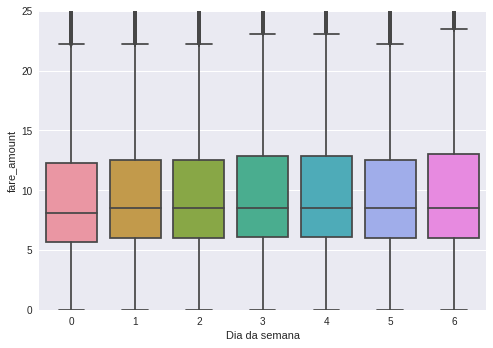

In [244]:
# fazendo uma análise usando o boxplot temos

sbs.boxplot(x='Dia da semana', y='fare_amount',data=chunk)
plt.ylim((0,25))

Observando as análises dos gráficos e dos boxplot, creio que não há muita relação entre a taxa e o dia da semana

#**Hipótese 4**


---

O local onde o taxi foi pego tem relação com a taxa?

In [0]:
#lcoordenadas do centro de nova york
lat_center = 40.77
lon_center = -73.96

#plot
map_ny = folium.Map(location=[lat_center,lon_center],
                    tiles="openstreetmap",max_zoom=15,zoom_start=11.5)
map_ny

In [0]:
trips_ln = chunk[chunk['distancia'] > 40]

lat_center = 40.78
lon_center = -73.62

map_nyc = folium.Map(location=[lat_center,lon_center],
                    tiles="stamentoner",max_zoom=10,zoom_start=10)


for i in range(0,len(trips_ln)) : 
    
    p1 = [trips_ln["pickup_latitude"].values[i],
          trips_ln["pickup_longitude"].values[i]]
    
    p2 = [trips_ln["dropoff_latitude"].values[i],
          trips_ln["dropoff_longitude"].values[i]]
    
    folium.Marker(location = p1,
                  icon=folium.Icon(color='green',
                                   icon = "home"),
                  popup = "Pick up = " + str(p1),
                 ).add_to(map_nyc)
    
    folium.Marker(location = p2,
                 icon=folium.Icon(color='blue',
                                  icon = "home"),
                  popup = "Drop off = " + str(p2),
                 ).add_to(map_nyc)
    
    folium.PolyLine(locations = [p1,p2] ,
                    color = "red",opacity = .9,
                   ).add_to(map_nyc)
    
   
map_nyc

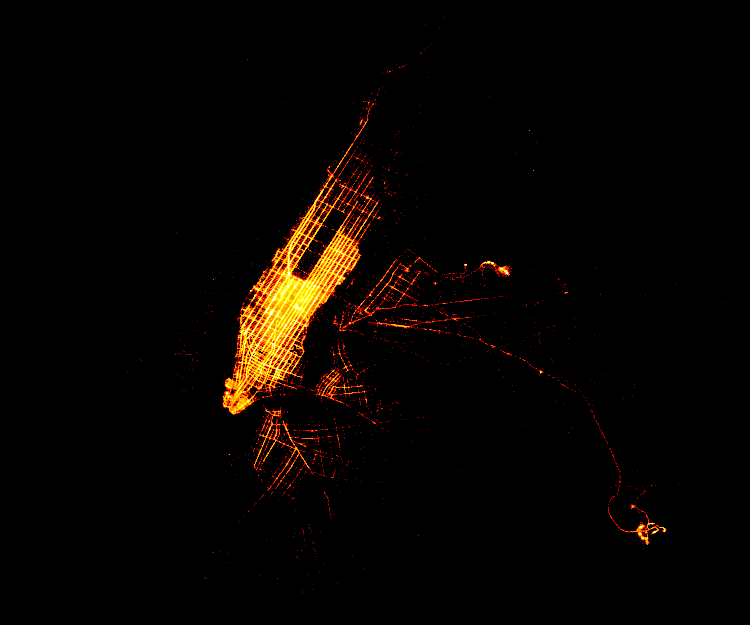

In [290]:
# função para plotar as coordenadas no mapa de NYC

def plot_data_points(longitude,latitude,data_frame,focus_point) :
    #plot dimensions
    x_range, y_range = ((-74.14,-73.73), (40.6,40.9))
    plot_width  = int(750)
    plot_height = int(plot_width//1.2)
    export  = partial(export_image, export_path="export", background="black")
    fig = figure(background_fill_color = "black")    
    #plot data points
    cvs = ds.Canvas(plot_width=plot_width, plot_height=plot_height,
                    x_range=x_range, y_range=y_range)
    agg = cvs.points(data_frame,longitude,latitude,
                      ds.count(focus_point))
    img = tf.shade(agg, cmap= Hot, how='eq_hist')
    image_xpt  =  tf.dynspread(img, threshold=0.5, max_px=4)
    return export(image_xpt,"NYCT_hot")

  
plot_data_points('pickup_longitude', 'pickup_latitude',chunk,'fare_amount')

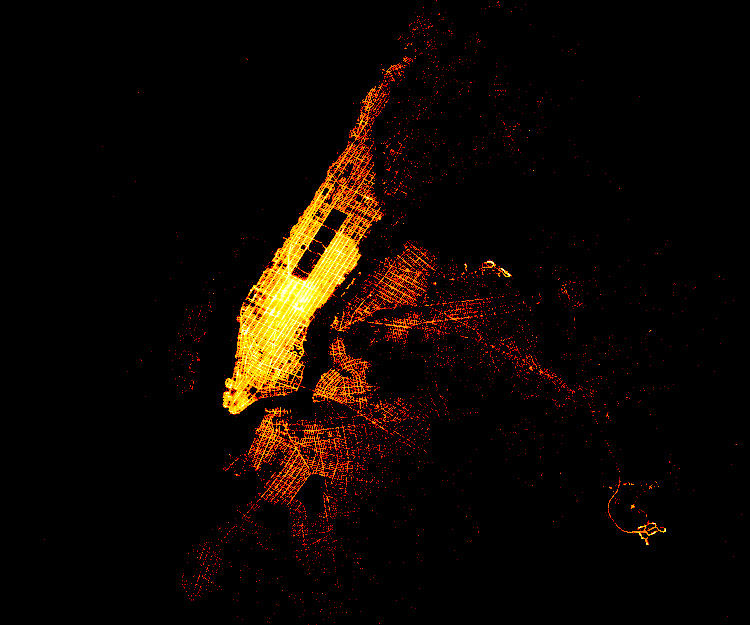

In [291]:
plot_data_points('dropoff_longitude', 'dropoff_latitude',chunk,"fare_amount")